In [21]:
%pip install pandas
%pip install -U scikit-learn
%pip install xgboost
%pip install seaborn
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [22]:
# ----------------------------
# Config
# ----------------------------
WINDOW_SIZE = 2  # use past 2 days
RANDOM_STATE = 8
WEIGHTED_RATIO_MULTIPLIER = 0.25
CUSTOM_THRESHOLD = 0.5  # custom threshold for classification
DROPOUT_RATE = 0.4  # dropout rate

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from IPython.display import display

# Define base features (original, non-lagged)
base_features = [
    "rainfall_3day_cumulative_mm",
    "rainfall_5day_cumulative_mm",
    "rainfall_7day_cumulative_mm",
    "rainfall_max_mm",
    "rainfall_mean_mm",
    "rainfall_std_mm",
    "soil_moisture_top10cm_mm",
    "subsurface_runoff_mm",
    "surface_runoff_mm",
]

def preprocess_date(file_str):
    
    # ----------------------------
    # 1. Load Data
    # ----------------------------
    df = pd.read_csv(file_str, parse_dates=["date"],
                 date_parser=lambda x: pd.to_datetime(x, format="%m/%d/%Y"))
    df.drop(columns=[".geo", "system:index"], inplace=True)  # drop index column if exists
    flood_dates = pd.read_csv("flood_ground_truth.csv", parse_dates=["Flood Date"])

    # Add flood label (binary)
    df["is_flood"] = df["date"].isin(flood_dates["Flood Date"]).astype(int)

    # Drop rows with date before 2000-01-01 due to missing moitsture data
    df = df[df["date"] >= "2000-01-01"]
    # Sort by time to maintain chronological order
    df = df.sort_values("date").reset_index(drop=True)
    display(df.head())
    
    # ----------------------------
    # 2. Handle Missing / Fake Zero Values
    # ----------------------------
    # Replace 0 with NaN (only if 0 indicates missing)
    for col in base_features:
        df[col] = df[col].replace(0, np.nan)
        df[col] = df[col].replace(-9999, np.nan)

    # Create 'day-of-year' for seasonal imputation
    df['doy'] = df['date'].dt.dayofyear

    # Impute NaNs using seasonal (day-of-year) mean
    for col in base_features:
        seasonal_avg = df.groupby('doy')[col].transform('mean')
        df[col] = df[col].fillna(seasonal_avg)

    # Drop the helper column
    df.drop(columns=['doy'], inplace=True)

    # ----------------------------
    # 3. Create Temporal Lag Features
    # ----------------------------
    for lag in range(1, WINDOW_SIZE + 1):
        for col in base_features:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    # Drop initial rows that have NaNs due to lagging
    df = df.dropna().reset_index(drop=True)
    # Print the shape of the DataFrame after preprocessing
    print(f"DataFrame shape after preprocessing: {df.shape}")
    # df.to_csv("preprocess_features.csv", index=False)
    return df


# ----------------------------
# 4. Prepare Train/Test Sets (Chronological Split)
# ----------------------------
df = preprocess_date("dataset/Flood_Features.csv")

split_index = int(len(df) * 0.7)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# X: use only lag features
X_train = train_df.drop(columns=["date", "is_flood"] + base_features)
X_test = test_df.drop(columns=["date", "is_flood"] + base_features)
y_train = train_df["is_flood"]
y_test = test_df["is_flood"]

/tmp/ipykernel_96969/655324413.py:27: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(file_str, parse_dates=["date"],


,date,rainfall_3day_cumulative_mm,rainfall_5day_cumulative_mm,rainfall_7day_cumulative_mm,rainfall_max_mm,rainfall_mean_mm,rainfall_std_mm,soil_moisture_top10cm_mm,subsurface_runoff_mm,surface_runoff_mm,is_flood
0,2000-01-01,1.552315,1.552315,1.552315,9.633512,1.780658,3.177049,34.776390,1.188814,0.003935,0
1,2000-01-02,7.195744,7.195744,7.195744,20.349800,5.878247,6.757485,35.755472,2.805128,0.000000,0
2,2000-01-03,7.195744,7.195744,7.195744,0.000000,0.000000,0.000000,35.286133,2.655712,0.000000,0
3,2000-01-04,5.643429,7.195744,7.195744,0.000000,0.000000,0.000000,34.918411,2.456230,0.000000,0
4,2000-01-05,0.000000,7.195744,7.195744,0.000000,0.000000,0.000000,34.613084,2.238542,0.000000,0


DataFrame shape after preprocessing: (9130, 29)


In [24]:
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
# ----------------------------
# 5. Apply SMOTE for Imbalanced Data
# ----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def apply_smote(X_train_scaled, y_train):
    # Apply SMOTE to training set only
    sm = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)
    
    print("Before SMOTE:", np.bincount(y_train))
    print("After SMOTE:", np.bincount(y_resampled))
    
    return X_resampled, y_resampled

def confusion_matrix_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    # Define labels
    labels = ["No Flood", "Flood"]

    # Plot nicely
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [25]:
import torch
# -----------------------------------------
# Define imbalance weights
# -----------------------------------------
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
print(neg / pos)
pos_weight = torch.tensor([(neg / pos)], dtype=torch.float32) * WEIGHTED_RATIO_MULTIPLIER
print('pos_weight:', pos_weight)

41.60666666666667
pos_weight: tensor([10.4017])


Before SMOTE: [6241  150]
After SMOTE: [6241 6241]


/home/kaos/AfterGradEx/time_series/flood_predicition/.venv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:59:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


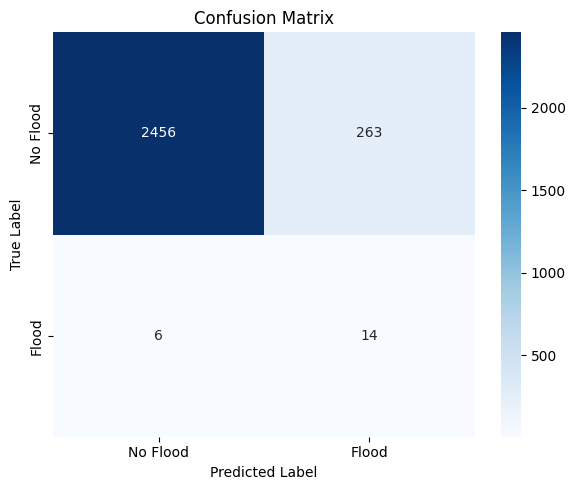

{'No Flood': {'precision': 0.9975629569455727, 'recall': 0.9032732622287606, 'f1-score': 0.948079521327929, 'support': 2719.0}, 'Flood': {'precision': 0.05054151624548736, 'recall': 0.7, 'f1-score': 0.09427609427609426, 'support': 20.0}, 'accuracy': 0.9017889740781307, 'macro avg': {'precision': 0.52405223659553, 'recall': 0.8016366311143803, 'f1-score': 0.5211778078020116, 'support': 2739.0}, 'weighted avg': {'precision': 0.990647867929873, 'recall': 0.9017889740781307, 'f1-score': 0.9418451041899092, 'support': 2739.0}}
ROC AUC: 0.9017653549098933


In [26]:
import numpy as np
from sklearn.metrics import precision_recall_curve, fbeta_score

def xgboost_classification_report(X_train_scaled, X_test_scaled, y_train, y_test):

    # ----------------------------
    # Train XGBoost Classifier
    # ----------------------------
    # Calculate class imbalance ratio
    # scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() * WEIGHTED_RATIO_MULTIPLIER

    xgb = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        # scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
           eval_metric='aucpr',
        random_state=RANDOM_STATE
    )

    xgb.fit(X_train_scaled, y_train)

    # ----------------------------
    # Evaluate Model
    # ----------------------------
    # Predict probability of flood (class 1)
    y_prob = xgb.predict_proba(X_test_scaled)[:, 1]
    # Apply custom threshold
    y_pred = (y_prob > CUSTOM_THRESHOLD).astype(int)

     # Metrics
    report = (classification_report(y_test, y_pred, target_names=["No Flood", "Flood"],  output_dict=True))
    conf_matrix = confusion_matrix_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    print(report)
    print("ROC AUC:", roc_auc_score(y_test, y_prob))

    # probs: model output probabilities for "Flood" class
    # y_true: ground truth binary labels (0 for No Flood, 1 for Flood)

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

    return {
        "F1_NoFlood": report["No Flood"]["f1-score"],
        "F1_Flood": report["Flood"]["f1-score"],
        "Precision_Flood": report["Flood"]["precision"],
        "Recall_Flood": report["Flood"]["recall"],
        "ROC_AUC": roc_auc,
        "ConfusionMatrix": conf_matrix,
    }

X_train_resampled, y_train_resampled = apply_smote(X_train_scaled, y_train)

xgboots_results = xgboost_classification_report(X_train_resampled, X_test_scaled, y_train_resampled, y_test)


In [27]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# -----------------------------------------
# Define evaluation function
# -----------------------------------------
def evaluate_model(model, X_test_tensor, y_test_tensor):
    with torch.no_grad():
        logits = model(X_test_tensor)                      # raw outputs
        probs = torch.sigmoid(logits).numpy().flatten()    # convert to [0,1] range

    # ✅ Use custom threshold
    y_pred = (probs > CUSTOM_THRESHOLD).astype(int)

    y_true = y_test_tensor.numpy().flatten()

    # Metrics
    report = (classification_report(y_true, y_pred, target_names=["No Flood", "Flood"],  output_dict=True))
    conf_matrix = confusion_matrix_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_true, probs)
    print(report)
    print("ROC AUC:", roc_auc_score(y_true, probs))

    return {
        "F1_NoFlood": report["No Flood"]["f1-score"],
        "F1_Flood": report["Flood"]["f1-score"],
        "Precision_Flood": report["Flood"]["precision"],
        "Recall_Flood": report["Flood"]["recall"],
        "ROC_AUC": roc_auc,
        "ConfusionMatrix": conf_matrix,
    }

# -----------------------------------------
# Plotting function
# -----------------------------------------
def plot_learning(train_losses, val_losses, model):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    model.eval()

# ----------------------------
# Train the model
# ----------------------------
def train_model(model, train_loader, test_loader, num_epochs=40, pos_weight=None):
    train_losses = []
    val_losses = []
    # -----------------------------------------
    # Handle class imbalance using pos_weight
    # -----------------------------------------
   
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)  # raw logits
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in test_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_targets)
                val_running_loss += val_loss.item()
        avg_val_loss = val_running_loss / len(test_loader)
        val_losses.append(avg_val_loss)
    return train_losses, val_losses

In [29]:

# Check CUDA (optional)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))


# -----------------------------------------
# Convert to torch tensors (after SMOTE + scaling)
# -----------------------------------------
def mlp_data_prep(X_train_resampled, y_train_resampled, X_test_scaled, y_test):
    X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).unsqueeze(1)

    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, train_loader, test_loader

mlp_X_train_tensor, mlp_y_train_tensor, mlp_X_test_tensor, mlp_y_test_tensor, mlp_train_loader, mlp_test_loader = mlp_data_prep(X_train_resampled, y_train_resampled, X_test_scaled, y_test)

CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


In [30]:
# -----------------------------------------
# Define the MLP model
# -----------------------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 1)
            # nn.Sigmoid() # No sigmoid here!
        )

    def forward(self, x):
        return self.net(x)


Epoch [1/40], Loss: 0.3753
Epoch [2/40], Loss: 0.2951
Epoch [3/40], Loss: 0.2754
Epoch [4/40], Loss: 0.2727
Epoch [5/40], Loss: 0.2627
Epoch [6/40], Loss: 0.2556
Epoch [7/40], Loss: 0.2558
Epoch [8/40], Loss: 0.2527
Epoch [9/40], Loss: 0.2443
Epoch [10/40], Loss: 0.2437
Epoch [11/40], Loss: 0.2334
Epoch [12/40], Loss: 0.2235
Epoch [13/40], Loss: 0.2309
Epoch [14/40], Loss: 0.2264
Epoch [15/40], Loss: 0.2166
Epoch [16/40], Loss: 0.2154
Epoch [17/40], Loss: 0.2119
Epoch [18/40], Loss: 0.2144
Epoch [19/40], Loss: 0.2065
Epoch [20/40], Loss: 0.2042
Epoch [21/40], Loss: 0.2028
Epoch [22/40], Loss: 0.2049
Epoch [23/40], Loss: 0.1989
Epoch [24/40], Loss: 0.1983
Epoch [25/40], Loss: 0.1971
Epoch [26/40], Loss: 0.2025
Epoch [27/40], Loss: 0.2007
Epoch [28/40], Loss: 0.1965
Epoch [29/40], Loss: 0.1873
Epoch [30/40], Loss: 0.1995
Epoch [31/40], Loss: 0.1880
Epoch [32/40], Loss: 0.1978
Epoch [33/40], Loss: 0.1890
Epoch [34/40], Loss: 0.1896
Epoch [35/40], Loss: 0.1798
Epoch [36/40], Loss: 0.1771
E

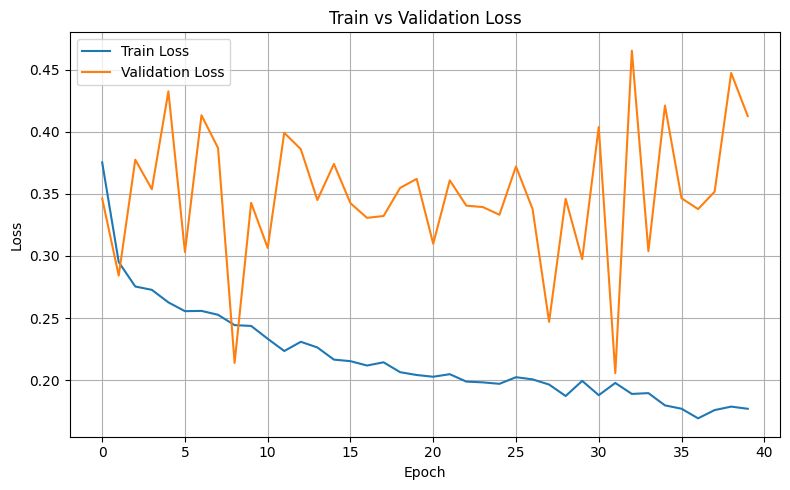

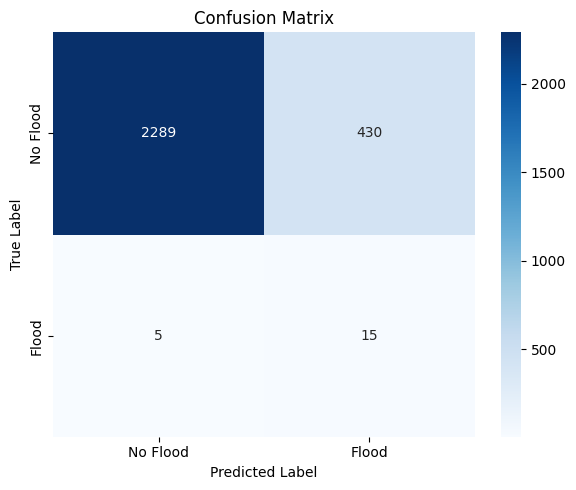

{'No Flood': {'precision': 0.9978204010462075, 'recall': 0.841853622655388, 'f1-score': 0.9132256134051466, 'support': 2719.0}, 'Flood': {'precision': 0.033707865168539325, 'recall': 0.75, 'f1-score': 0.06451612903225806, 'support': 20.0}, 'accuracy': 0.8411829134720701, 'macro avg': {'precision': 0.5157641331073735, 'recall': 0.795926811327694, 'f1-score': 0.4888708712187023, 'support': 2739.0}, 'weighted avg': {'precision': 0.9907805139642238, 'recall': 0.8411829134720701, 'f1-score': 0.9070283919055272, 'support': 2739.0}}
ROC AUC: 0.8099485104817948


In [31]:
# ----------------------------
# Train the model
# ----------------------------
mlp_model = MLPClassifier(input_dim=X_train.shape[1])
train_mlp_losses, val_mlp_losses = train_model(mlp_model, mlp_train_loader, mlp_test_loader)

# -----------------------------------------
# Evaluation
# -----------------------------------------
plot_learning(train_mlp_losses, val_mlp_losses, mlp_model)
mlp_results = evaluate_model(mlp_model, mlp_X_test_tensor, mlp_y_test_tensor)

In [32]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming X_train_resampled.shape = (N, num_features)
num_features_per_step = len(base_features)
element_per_step = num_features_per_step * WINDOW_SIZE

# Reshape to match CNN input shape
def reshape_to_cnn_input(X):
    return X.reshape((-1, num_features_per_step, WINDOW_SIZE))

# -----------------------------------------
# Convert to torch tensors (without SMOTE + scaling)
# -----------------------------------------
def cnn_data_prep(X_train_scaled, y_train, X_test_scaled, y_test):
    X_train = reshape_to_cnn_input(X_train_scaled)
    X_test = reshape_to_cnn_input(X_test_scaled)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    print(X_train_tensor.shape, y_train_tensor.shape)
    print(X_test_tensor.shape, y_test_tensor.shape)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)
  
    return X_test_tensor, y_test_tensor, train_loader, test_loader

cnn_X_test_tensor, cnn_y_test_tensor, cnn_train_loader, cnn_test_loader = cnn_data_prep(X_train_scaled, y_train, X_test_scaled, y_test)

torch.Size([6391, 9, 2]) torch.Size([6391, 1])
torch.Size([2739, 9, 2]) torch.Size([2739, 1])


In [33]:
import torch.nn as nn

# -----------------------------------------
# Define the CNN model
# -----------------------------------------
class CNN1DClassifier(nn.Module):
    def __init__(self, in_channels, sequence_length):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(64 * sequence_length, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # No sigmoid
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        return self.fc(x)


Epoch [1/40], Loss: 0.5125
Epoch [2/40], Loss: 0.3846
Epoch [3/40], Loss: 0.3566
Epoch [4/40], Loss: 0.3296
Epoch [5/40], Loss: 0.3254
Epoch [6/40], Loss: 0.3091
Epoch [7/40], Loss: 0.3405
Epoch [8/40], Loss: 0.3242
Epoch [9/40], Loss: 0.3082
Epoch [10/40], Loss: 0.3341
Epoch [11/40], Loss: 0.3112
Epoch [12/40], Loss: 0.3145
Epoch [13/40], Loss: 0.3263
Epoch [14/40], Loss: 0.2984
Epoch [15/40], Loss: 0.3076
Epoch [16/40], Loss: 0.2934
Epoch [17/40], Loss: 0.2906
Epoch [18/40], Loss: 0.2870
Epoch [19/40], Loss: 0.3109
Epoch [20/40], Loss: 0.2860
Epoch [21/40], Loss: 0.2992
Epoch [22/40], Loss: 0.2832
Epoch [23/40], Loss: 0.2900
Epoch [24/40], Loss: 0.2839
Epoch [25/40], Loss: 0.2875
Epoch [26/40], Loss: 0.2847
Epoch [27/40], Loss: 0.2861
Epoch [28/40], Loss: 0.2897
Epoch [29/40], Loss: 0.3115
Epoch [30/40], Loss: 0.2776
Epoch [31/40], Loss: 0.2735
Epoch [32/40], Loss: 0.2790
Epoch [33/40], Loss: 0.2888
Epoch [34/40], Loss: 0.2841
Epoch [35/40], Loss: 0.2812
Epoch [36/40], Loss: 0.2702
E

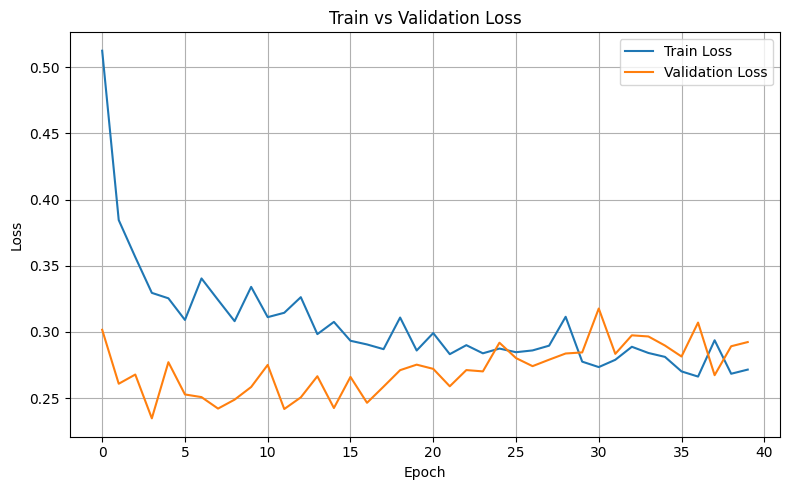

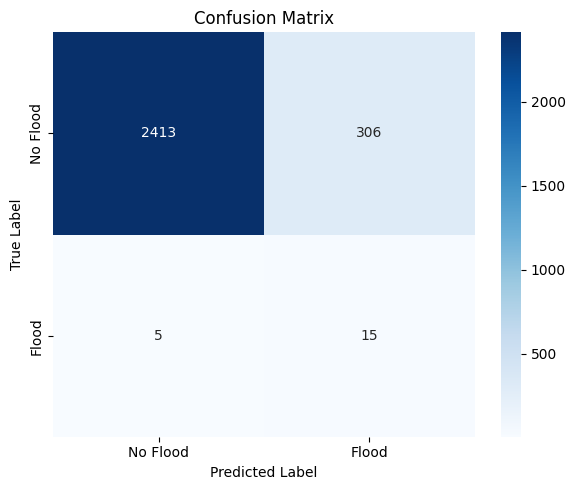

{'No Flood': {'precision': 0.9979321753515302, 'recall': 0.8874586244942994, 'f1-score': 0.9394588281097918, 'support': 2719.0}, 'Flood': {'precision': 0.04672897196261682, 'recall': 0.75, 'f1-score': 0.0879765395894428, 'support': 20.0}, 'accuracy': 0.8864549105512961, 'macro avg': {'precision': 0.5223305736570735, 'recall': 0.8187293122471497, 'f1-score': 0.5137176838496172, 'support': 2739.0}, 'weighted avg': {'precision': 0.9909865513764378, 'recall': 0.8864549105512961, 'f1-score': 0.9332413597744844, 'support': 2739.0}}
ROC AUC: 0.8500551673409342


In [34]:
# ----------------------------
# Train the CNN model with weighted loss
# ----------------------------
cnn_model = CNN1DClassifier(in_channels=num_features_per_step, sequence_length=WINDOW_SIZE)
train_cnn_losses, val_cnn_losses = train_model(cnn_model, cnn_train_loader, cnn_test_loader, num_epochs=40, pos_weight=pos_weight)
# -----------------------------------------
# Evaluation
# -----------------------------------------
plot_learning(train_cnn_losses, val_cnn_losses, cnn_model)
weighted_loss_cnn_results = evaluate_model(cnn_model, cnn_X_test_tensor, cnn_y_test_tensor)

In [35]:
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
# Convert to torch tensors and prepare DataLoaders
def cnn_wighted_data_prep(X_train_scaled, y_train, X_test_scaled, y_test):
    # Reshape input for CNN
    X_train = reshape_to_cnn_input(X_train_scaled)
    X_test = reshape_to_cnn_input(X_test_scaled)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    print("Train set:", X_train_tensor.shape, y_train_tensor.shape)
    print("Test set:", X_test_tensor.shape, y_test_tensor.shape)

    # ------------------------
    # WeightedRandomSampler
    # ------------------------
    labels = y_train_tensor.squeeze().numpy().astype(int)  # Ensure 1D int array
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    sample_weights = class_weights[labels]

    print("Sample weights:", sample_weights)

    sampler = WeightedRandomSampler(
        weights=torch.tensor(sample_weights, dtype=torch.float32),
        num_samples=len(sample_weights),
        replacement=True
    )

    # DataLoaders
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=32,
        sampler=sampler  # Use sampler instead of shuffle
    )

    test_loader = DataLoader(
        TensorDataset(X_test_tensor, y_test_tensor),
        batch_size=32,
        shuffle=False
    )

    return X_test_tensor, y_test_tensor, train_loader, test_loader

# Usage
cnn_X_test_tensor, cnn_y_test_tensor, cnn_train_loader, cnn_test_loader = cnn_wighted_data_prep(
    X_train_scaled, y_train, X_test_scaled, y_test
)

Train set: torch.Size([6391, 9, 2]) torch.Size([6391, 1])
Test set: torch.Size([2739, 9, 2]) torch.Size([2739, 1])
Sample weights: [0.00016023 0.00016023 0.00016023 ... 0.00016023 0.00016023 0.00016023]


Epoch [1/40], Loss: 0.4121
Epoch [2/40], Loss: 0.3324
Epoch [3/40], Loss: 0.3183
Epoch [4/40], Loss: 0.3238
Epoch [5/40], Loss: 0.2943
Epoch [6/40], Loss: 0.2885
Epoch [7/40], Loss: 0.2865
Epoch [8/40], Loss: 0.2630
Epoch [9/40], Loss: 0.2827
Epoch [10/40], Loss: 0.2747
Epoch [11/40], Loss: 0.2668
Epoch [12/40], Loss: 0.2547
Epoch [13/40], Loss: 0.2541
Epoch [14/40], Loss: 0.2693
Epoch [15/40], Loss: 0.2513
Epoch [16/40], Loss: 0.2419
Epoch [17/40], Loss: 0.2614
Epoch [18/40], Loss: 0.2260
Epoch [19/40], Loss: 0.2366
Epoch [20/40], Loss: 0.2324
Epoch [21/40], Loss: 0.2327
Epoch [22/40], Loss: 0.2309
Epoch [23/40], Loss: 0.2373
Epoch [24/40], Loss: 0.2356
Epoch [25/40], Loss: 0.2224
Epoch [26/40], Loss: 0.2264
Epoch [27/40], Loss: 0.2322
Epoch [28/40], Loss: 0.2148
Epoch [29/40], Loss: 0.2138
Epoch [30/40], Loss: 0.2145
Epoch [31/40], Loss: 0.2195
Epoch [32/40], Loss: 0.2161
Epoch [33/40], Loss: 0.2118
Epoch [34/40], Loss: 0.2201
Epoch [35/40], Loss: 0.2034
Epoch [36/40], Loss: 0.1953
E

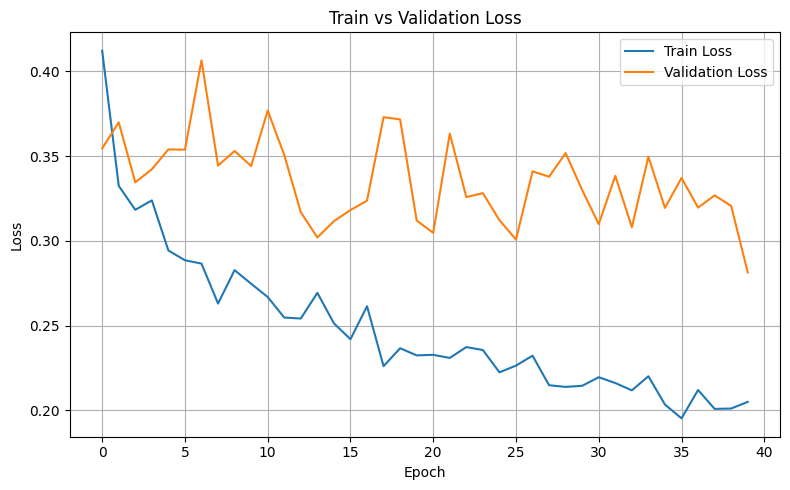

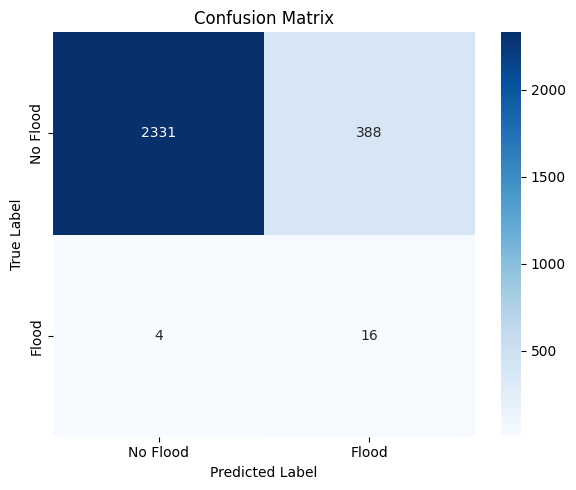

{'No Flood': {'precision': 0.9982869379014989, 'recall': 0.8573004781169548, 'f1-score': 0.9224376731301939, 'support': 2719.0}, 'Flood': {'precision': 0.039603960396039604, 'recall': 0.8, 'f1-score': 0.07547169811320754, 'support': 20.0}, 'accuracy': 0.8568820737495436, 'macro avg': {'precision': 0.5189454491487693, 'recall': 0.8286502390584773, 'f1-score': 0.4989546856217007, 'support': 2739.0}, 'weighted avg': {'precision': 0.9912866971018971, 'recall': 0.8568820737495436, 'f1-score': 0.9162531826225854, 'support': 2739.0}}
ROC AUC: 0.8363184994483266


In [36]:
# ----------------------------
# Re-Train the model
# ----------------------------
weighted_data_cnn_model = CNN1DClassifier(in_channels=num_features_per_step, sequence_length=WINDOW_SIZE)
train_cnn_losses, val_cnn_losses = train_model(weighted_data_cnn_model, cnn_train_loader, cnn_test_loader)
# -----------------------------------------
# Evaluation
# -----------------------------------------
plot_learning(train_cnn_losses, val_cnn_losses, weighted_data_cnn_model)
weighted_data_cnn_results = evaluate_model(weighted_data_cnn_model, cnn_X_test_tensor, cnn_y_test_tensor)

In [37]:
def reshape_to_lstm_input(X):
    # Reshape to (samples, window_size, num_features_per_step)
    return X.reshape((-1, WINDOW_SIZE, num_features_per_step))

def lstm_weigted_data_prep(X_train_scaled, y_train, X_test_scaled, y_test):
    # Reshape input for LSTM
    X_train = reshape_to_lstm_input(X_train_scaled)
    X_test = reshape_to_lstm_input(X_test_scaled)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    print("Train set:", X_train_tensor.shape, y_train_tensor.shape)
    print("Test set:", X_test_tensor.shape, y_test_tensor.shape)

    # WeightedRandomSampler
    labels = y_train_tensor.squeeze().numpy().astype(int)
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    sample_weights = class_weights[labels]

    print("Sample weights:", sample_weights)

    sampler = WeightedRandomSampler(
        weights=torch.tensor(sample_weights, dtype=torch.float32),
        num_samples=len(sample_weights),
        replacement=True
    )

    # DataLoaders
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=32,
        sampler=sampler
    )

    test_loader = DataLoader(
        TensorDataset(X_test_tensor, y_test_tensor),
        batch_size=32,
        shuffle=False
    )

    return X_test_tensor, y_test_tensor, train_loader, test_loader

# Usage
lstm_X_test_tensor, lstm_y_test_tensor, lstm_train_loader, lstm_test_loader = lstm_weigted_data_prep(
    X_train_scaled, y_train, X_test_scaled, y_test
)

Train set: torch.Size([6391, 2, 9]) torch.Size([6391, 1])
Test set: torch.Size([2739, 2, 9]) torch.Size([2739, 1])
Sample weights: [0.00016023 0.00016023 0.00016023 ... 0.00016023 0.00016023 0.00016023]


In [38]:
import torch.nn as nn

# -----------------------------------------
# Define the LSTM model
# -----------------------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, dropout=DROPOUT_RATE):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)  # No sigmoid
        )

    def forward(self, x):
        # x: [batch, seq_len, input_size]
        lstm_out, _ = self.lstm(x)
        # Use the last time step's output
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out) 

/home/kaos/AfterGradEx/time_series/flood_predicition/.venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/40], Loss: 0.5084
Epoch [2/40], Loss: 0.3131
Epoch [3/40], Loss: 0.2941
Epoch [4/40], Loss: 0.2834
Epoch [5/40], Loss: 0.2727
Epoch [6/40], Loss: 0.2564
Epoch [7/40], Loss: 0.2533
Epoch [8/40], Loss: 0.2405
Epoch [9/40], Loss: 0.2394
Epoch [10/40], Loss: 0.2411
Epoch [11/40], Loss: 0.2423
Epoch [12/40], Loss: 0.2152
Epoch [13/40], Loss: 0.2193
Epoch [14/40], Loss: 0.2229
Epoch [15/40], Loss: 0.2048
Epoch [16/40], Loss: 0.2088
Epoch [17/40], Loss: 0.1945
Epoch [18/40], Loss: 0.1984
Epoch [19/40], Loss: 0.1939
Epoch [20/40], Loss: 0.1919
Epoch [21/40], Loss: 0.1787
Epoch [22/40], Loss: 0.1859
Epoch [23/40], Loss: 0.1782
Epoch [24/40], Loss: 0.1713
Epoch [25/40], Loss: 0.1663
Epoch [26/40], Loss: 0.1541
Epoch [27/40], Loss: 0.1475
Epoch [28/40], Loss: 0.1650
Epoch [29/40], Loss: 0.1468
Epoch [30/40], Loss: 0.1422
Epoch [31/40], Loss: 0.1498
Epoch [32/40], Loss: 0.1426
Epoch [33/40], Loss: 0.1423
Epoch [34/40], Loss: 0.1307
Epoch [35/40], Loss: 0.1344
Epoch [36/40], Loss: 0.1281
E

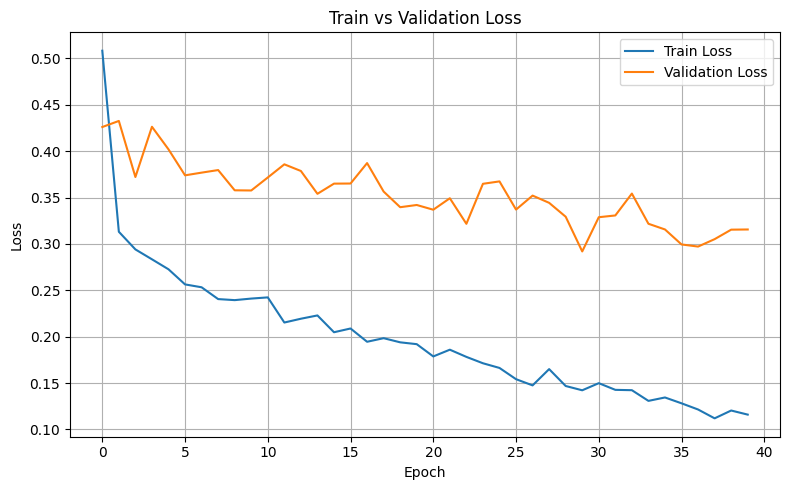

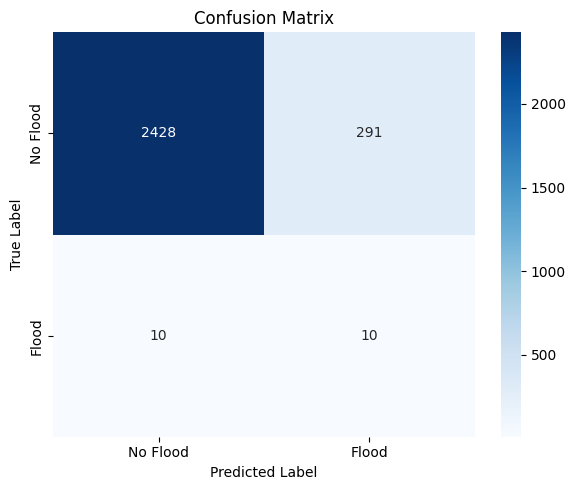

{'No Flood': {'precision': 0.9958982772764561, 'recall': 0.892975358587716, 'f1-score': 0.9416327322086484, 'support': 2719.0}, 'Flood': {'precision': 0.03322259136212625, 'recall': 0.5, 'f1-score': 0.06230529595015577, 'support': 20.0}, 'accuracy': 0.8901058780576853, 'macro avg': {'precision': 0.5145604343192912, 'recall': 0.696487679293858, 'f1-score': 0.5019690140794021, 'support': 2739.0}, 'weighted avg': {'precision': 0.9888688819795277, 'recall': 0.8901058780576853, 'f1-score': 0.9352119404141359, 'support': 2739.0}}
ROC AUC: 0.7965060684075027


In [39]:
# ----------------------------
# Train the LSTM model with weighted loss
# ----------------------------
lstm_model = LSTMClassifier(input_size=num_features_per_step, hidden_size=64, num_layers=1, dropout=DROPOUT_RATE)
train_lstm_losses, val_lstm_losses = train_model(lstm_model, lstm_train_loader, lstm_test_loader)
# -----------------------------------------
# Evaluation
# -----------------------------------------
plot_learning(train_lstm_losses, val_lstm_losses, lstm_model)
weighted_data_lstm_results = evaluate_model(lstm_model, lstm_X_test_tensor, lstm_y_test_tensor)

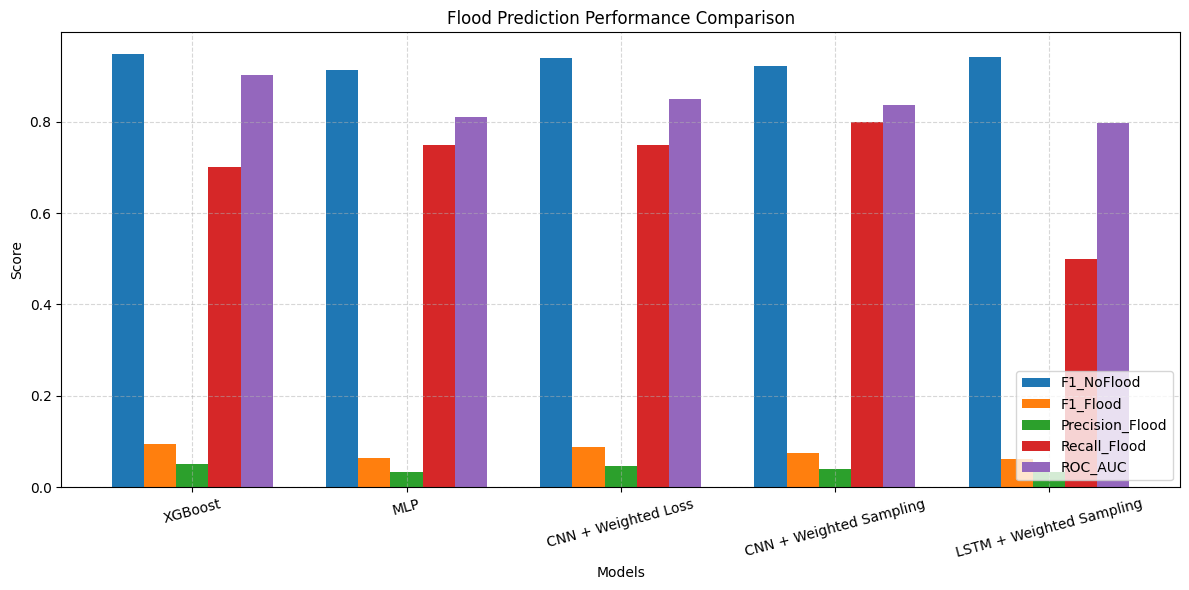

In [40]:
import json
import matplotlib.pyplot as plt
import numpy as np

def compare_results():
    # Collect results
    model_names = [
        "XGBoost",
        "MLP",
        "CNN + Weighted Loss",
        "CNN + Weighted Sampling",
        "LSTM + Weighted Sampling"
    ]

    metrics = ["F1_NoFlood", "F1_Flood", "Precision_Flood", "Recall_Flood", "ROC_AUC"]

    results = [
        xgboots_results,
        mlp_results,
        weighted_loss_cnn_results,
        weighted_data_cnn_results,
        weighted_data_lstm_results
    ]

     # Store combined results for saving
    combined_results = {
        model_names[i]: results[i] for i in range(len(model_names))
    }

    # Save to JSON
    with open("result.json", "w") as f:
        json.dump(combined_results, f, indent=4)

    # Prepare values for each metric
    metric_values = {metric: [model[metric] for model in results] for metric in metrics}

    # Plot grouped bar chart
    x = np.arange(len(model_names))  # model indices
    width = 0.15

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, metric_values[metric], width, label=metric)

    ax.set_xlabel("Models")
    ax.set_ylabel("Score")
    ax.set_title("Flood Prediction Performance Comparison")
    ax.set_xticks(x + width * (len(metrics) - 1) / 2)
    ax.set_xticklabels(model_names, rotation=15)
    ax.legend(loc="lower right")
    ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

compare_results()

In [41]:
# -----------------------------------------
# Export the best model
# -----------------------------------------
import torch
# Assuming weighted_data_cnn_model is already trained
MODEL_PATH = "weighted_data_cnn_model.pt"
torch.save(weighted_data_cnn_model.state_dict(), MODEL_PATH)
print(f"Model exported to {MODEL_PATH}")
# ----------------------------------------- 

Model exported to weighted_data_cnn_model.pt
